In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install lightning

In [1]:
import os
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
seed = 13
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.use_deterministic_algorithms(True)

plt.rcParams["figure.figsize"] = (12,6)

In [3]:
train_dir = "./data/train"
test_dir = "./data/test"

In [4]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

<h2>Do data engineering</h2>

In [5]:
def make_fname_class_df(train_dir):
    classes = os.listdir(train_dir)
    
    file_lst = []
    class_lst = []
    class_idx_lst = []
    for i, cl in enumerate(classes):
        path = train_dir + f"/{cl}"
        file_lst = file_lst + os.listdir(path)
        class_lst = class_lst + [cl]* len(os.listdir(path))
        class_idx_lst = class_idx_lst + [i]* len(os.listdir(path))
    full_df = pd.DataFrame({"file": file_lst, "class": class_lst,\
                              "class_idx": class_idx_lst})
    return full_df

full_df = make_fname_class_df(train_dir)
#full_df.tail(10)
        

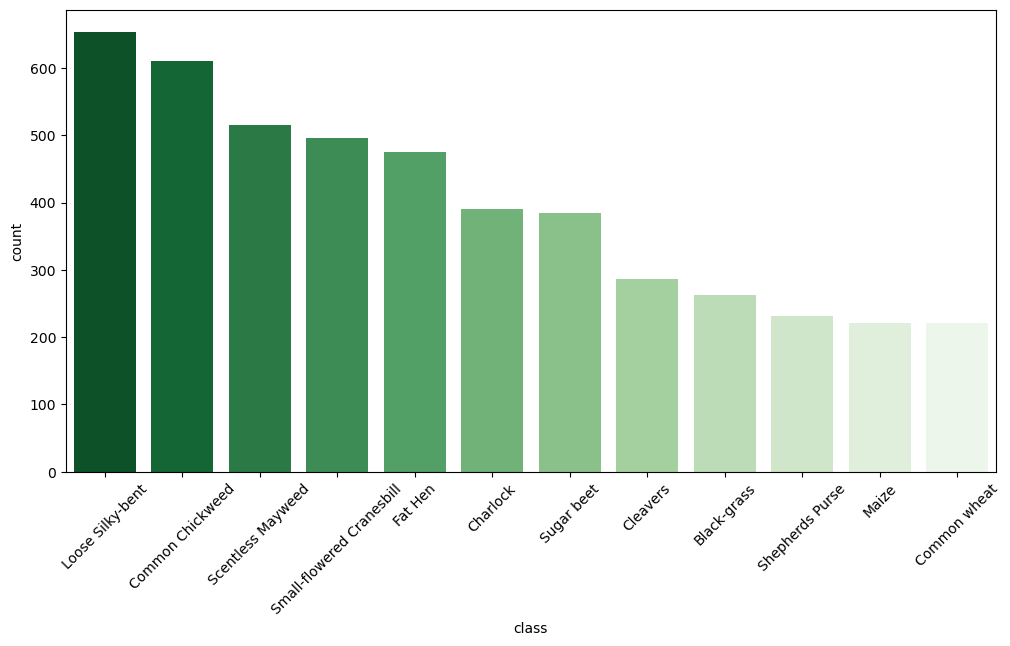

In [6]:
g = sns.countplot(data = full_df ,x = "class", order = full_df['class'].value_counts().index, palette='Greens_r')
plt.xticks(rotation=45);

In [7]:
def visualize_input_images(root_dir, images_df, n_images=10):
    random_img_idx_lst = random.sample(range(images_df.shape[0]), n_images)
    fig, axes = plt.subplots(nrows=2, ncols=int(n_images/ 2))
    for (img_idx, display_idx) in zip(random_img_idx_lst, range(n_images)):
        full_img_path = root_dir + f"/{images_df.loc[images_df.index[img_idx], 'class']}" \
            + f"/{images_df.loc[images_df.index[img_idx], 'file']}"
        display_row, display_col = int(display_idx/ (n_images/ 2)), display_idx% int(n_images/ 2)
        img = Image.open(full_img_path).convert("RGB")
        axes[display_row][display_col].imshow(img)
        axes[display_row][display_col].set_title(images_df.loc[images_df.index[img_idx], 'class'])
        axes[display_row][display_col].set_axis_off()
        #print(img.size)

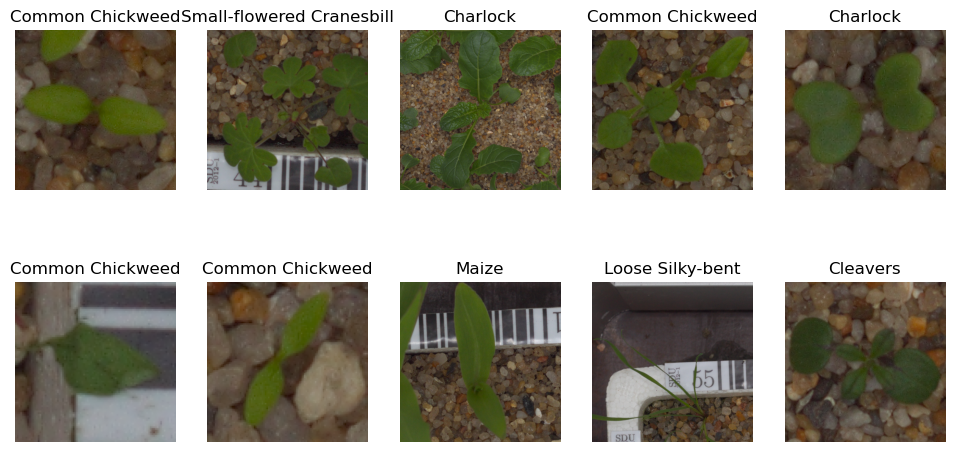

In [8]:
visualize_input_images(train_dir, full_df)

In [9]:
full_df["class"].unique().shape

(12,)

<h2>Prepare datamodule </h2>

In [10]:
import torch
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.transforms import v2 as tforms
from sklearn.model_selection import train_test_split

import lightning as L

In [11]:
class PlantTrainDataset(Dataset):
    
    def __init__(self, root_dir, transforms=None, target_transforms=None):
        self.root_dir = root_dir
        self.fname_class_df = make_fname_class_df(root_dir)
        self.transforms = transforms
        self.target_transforms = target_transforms
        
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}
    
    def idx_to_class(self):
        return dict(zip(range(len(self.classes)), self.classes))
    
    def __len__(self):
        return self.fname_class_df.shape[0]
    
    def __getitem__(self, idx):
        path = self.root_dir + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'class']}" \
            + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'file']}"
        image = Image.open(path).convert("RGB")
        target = self.fname_class_df.loc[self.fname_class_df.index[idx], "class_idx"]
        
        if self.transforms:
            image = self.transforms(image)
        if self.target_transforms:
            target = self.target_transforms(target)
        return image, target
        
class PlantTestDataset(Dataset):
    
    def __init__(self, root_dir, transforms=None, target_transforms=None):
        self.root_dir = root_dir
        self.fname_df = pd.DataFrame({"file": os.listdir(test_dir)})
        self.transforms = transforms
        self.target_transforms = target_transforms
    
    def __len__(self):
        return self.fname_df.shape[0]
    
    def __getitem__(self, idx):
        path = self.root_dir + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'file']}"
        image = Image.open(path).convert("RGB")
        
        if self.transforms:
            image = self.transforms(image)
        return image

In [12]:
def compute_mean_std(dataset, batch_size):
    rgb_values = torch.cat([img.reshape(3, -1) for img, target in dataset], dim=-1)
    rgb_values_chunks = rgb_values.split(224*224*batch_size, dim=1)
    
    rgb_mean_chunks = [torch.mean(chunk, dim=-1) for chunk in rgb_values_chunks] #list of tensor shape (3,)
    rgb_mean = torch.mean(torch.stack(rgb_mean_chunks, dim=0), dim=0).reshape((3, 1)) #shape (3, 1)
    
    rgb_var_chunks = [torch.mean((chunk - rgb_mean)** 2, dim=-1) for chunk in rgb_values_chunks]
    rgb_std = torch.sqrt(torch.mean(torch.stack(rgb_var_chunks, dim=0), dim=0))
    
    return rgb_mean.squeeze(), rgb_std

In [13]:
class PlantDataModule(L.LightningDataModule):
    def __init__(self, root_dir, test_dir, batch_size):
        super().__init__()
        self.root_dir = root_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.transform_lst = [
            tforms.ToImage(), 
            tforms.ToDtype(torch.uint8, scale=True),
            tforms.RandomAffine(degrees=10, translate=(0.2, 0.2)),
            tforms.RandomHorizontalFlip(),
            tforms.RandomVerticalFlip(),
            tforms.Resize((224, 224), antialias=True),
            tforms.ToDtype(torch.float32, scale=True)
        ]
        self.test_transform_lst = [
            tforms.ToImage(), 
            tforms.ToDtype(torch.uint8, scale=True),
            tforms.Resize((224, 224), antialias=True),
            tforms.ToDtype(torch.float32, scale=True)
        ]
        
    def prepare_data(self):
        # download
        pass

    def setup(self, stage: str):
        full_dataset = PlantTrainDataset(self.root_dir,\
                                 transforms=tforms.Compose([
                                    tforms.ToImage(), 
                                    tforms.ToDtype(torch.float32, scale=True),
                                ]))
        train_dataset, val_dataset = random_split(full_dataset, [0.8, 0.2],\
                                generator=torch.Generator().manual_seed(seed))
        train_mean, train_std = compute_mean_std(train_dataset,\
                                                 batch_size=self.batch_size)
        backbone_mean, backbone_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        self.transform_lst.append(tforms.Normalize(train_mean, train_std))
        self.test_transform_lst.append(tforms.Normalize(train_mean, train_std))
        full_dataset.transforms = tforms.Compose(self.transform_lst)
        
        self.train_dataset = train_dataset
        
        self.val_dataset = val_dataset
        
        self.predict_dataset = PlantTestDataset(self.test_dir,
            transforms=tforms.Compose(self.test_transform_lst)  
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False,\
                     pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False,\
                     pin_memory=True)

    def test_dataloader(self):
        pass

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False,\
                     pin_memory=True)


In [14]:
batch_size = 1
plant_data = PlantDataModule(train_dir, test_dir, batch_size)

<h2> Make classifier </h2>

In [15]:
import torchvision
import torch.nn as nn
import torchmetrics

In [16]:
class LightningPlantClassifier(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # init a pretrained resnet
        self.model = nn.Sequential(
            torch.nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1, -1),
            nn.Linear(5*5*64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        """ backbone = torchvision.models.shufflenet_v2_x0_5(weights="DEFAULT")
        self.features = nn.Sequential(*(list(backbone.children())[:-1]))
        num_ftrs = backbone.fc.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)
        
        for param in self.features.parameters():
            param.requires_grad = False """

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    
    def forward(self, x):
        """ ftrs = self.features(x)
        ftrs = ftrs.view(ftrs.size(0), -1)
        y = self.classifier(ftrs)
        return y """
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_evaluation_step(batch, batch_idx)
        metrics = {"loss": loss, "train_accuracy": acc}
        self.log_dict(metrics, prog_bar=True, logger=True, on_epoch=True)
        return metrics
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_evaluation_step(batch, batch_idx)
        metrics = {"validation_loss": loss, "validation_accuracy": acc}
        self.log_dict(metrics, prog_bar=True, logger=True, on_epoch=True)
        return metrics

    def predict_step(self, batch, batch_idx):
        inputs = batch
        outputs = self(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds
    
    def _shared_evaluation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        acc = self.accuracy(preds, targets)
        return loss, acc
    
    def configure_optimizers(self):
        """ return torch.optim.Adam(self.classifier.parameters(), lr=1e-3) """
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

In [17]:
backbone = torchvision.models.shufflenet_v2_x0_5(weights="DEFAULT")
backbone.named_children

<bound method Module.named_children of ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, mo

In [18]:
plant_model = LightningPlantClassifier(12)

In [19]:
trainer = L.Trainer(devices="auto", accelerator="gpu", deterministic=True, max_epochs=5)
trainer.fit(plant_model, datamodule=plant_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


: 

<h2>Testing </h2>

In [ ]:
y_preds = trainer.predict(plant_model, datamodule=plant_data)